In [1]:
import glob
import pickle
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family']='Helvetica'

In [45]:
from keras.models import Model, Sequential
from keras.layers import Conv1D,LSTM,Bidirectional,GRU,Input,Dropout,BatchNormalization,Reshape,Activation
from keras.layers import UpSampling1D,UpSampling2D


In [72]:
def generate_gaussian(mean,std=10,length=30000):
    x_values = np.arange(0,length)
    y_values = scipy.stats.norm(mean,std)
    y_values = y_values.pdf(x_values)
    #re-escale to peak at one
    y_values = y_values/np.max(y_values)
    # truncate at 2 sigmas
    y_truncated = np.zeros((30000))
    y_truncated[int(mean-2*std):int(mean+2*std)] = y_values[int(mean-2*std):int(mean+2*std)]
    
    return y_values,y_truncated

def generate_box(index1,index2):
    y_label = np.zeros((30000))
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def create_training_example(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    x     = data['data']
    y = np.zeros((5,30000))
    # check if the initial phase is Pg or Pn
    if data['Pn']!=0:
        box  = generate_box(data['Pn'],data['Sn'])
        _, y_pn = generate_gaussian(mean=data['Pn'])
        
    if data['Pg']!=0:
        box  = generate_box(data['Pg'],data['Sg'])
        _, y_pg = generate_gaussian(mean=data['Pg'])
        
    if data['Pn']==0:
        y_pn = np.zeros(30000)   
    if data['Pg']==0:
        y_pg = np.zeros(30000)
        
        
    if data['Sn']==0:
        y_sn = np.zeros(30000)
    if data['Sn']!=0:
        _, y_sn = generate_gaussian(mean=data['Sn'])
    
    if data['Sg']==0:
        y_sg = np.zeros(30000)
    if data['Sg']!=0:
        _,y_sg = generate_gaussian(mean=data['Sg'])
    
    #y = (box,y_pg,y_pn,y_sg,y_sn)
    
    y[0,:] = box; y[1,:] = y_pg; y[2,:] = y_pn; y[3,:] = y_sg; y[4,:] = y_sn;
    
        
    return x,y

def plot_example(x,y):
    plt.figure(figsize=(15,6))    
    for i in range(x.shape[0]):
        plt.subplot(3,1,i+1)
        
        plt.plot(x[i,:],c='k',linewidth=0.3,alpha=0.5)
        plt.plot(y[0,:],label='box')
        plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
        
        plt.xlim(0,30000)
        plt.legend(loc='upper right')
def load_multiple(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    filenames = glob.glob('data*pkl')[:m]
    # initialize tensors
    X = np.zeros((m,3,30000))
    Y = np.zeros((m,30000))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example(filename)
        X[i,:,:] = x
        Y[i,:]   = y
    return X,Y

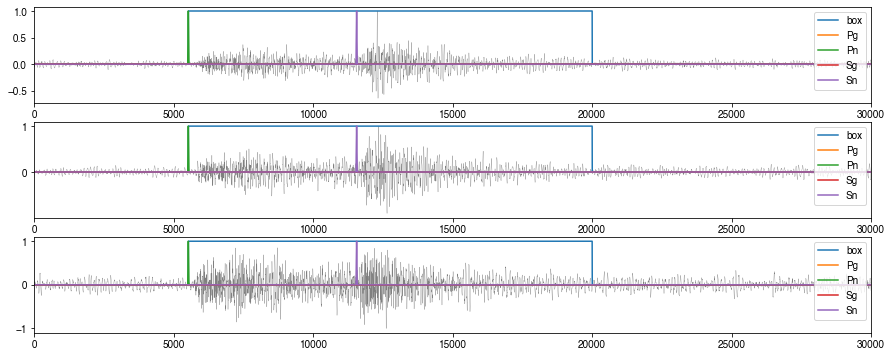

In [73]:
x1,y1 = create_training_example('data__Pn_3016.pkl')
plot_example(x1,y1)

In [5]:
X_train,Y_train = load_multiple(100)
print(X_train.shape,Y_train.shape)

(100, 3, 30000) (100, 30000)


In [51]:
def model(input_shape):
    
    
    X_input=Input(shape=input_shape)
    
    # A dense block
    X = Conv1D(filters=24,kernel_size=3,strides=2)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.8)(X)
    
    # Upsample
    #X = UpSampling2D(size=(1,2))(X)
    X = UpSampling1D(size=2)(X)
    
    
    model = Model(inputs=X_input,outputs=X)
    
    return model

In [52]:
#model = model(input_shape=(X_train.shape[0],X_train.shape[1]))
model = model(input_shape=(3,30000))

In [53]:
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3, 30000)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1, 24)             2160024   
_________________________________________________________________
batch_normalization_15 (Batc (None, 1, 24)             96        
_________________________________________________________________
activation_15 (Activation)   (None, 1, 24)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1, 24)             0         
_________________________________________________________________
up_sampling1d_5 (UpSampling1 (None, 2, 24)             0         
Total params: 2,160,120
Trainable params: 2,160,072
Non-trainable params: 48
_______________________________________________